# Semantic Segmentation Lab
In this lab, you will build a deep learning network that locates a particular human target within an image.  The premise is that a quadcopter (simulated) is searching for a target, and then will follow the target once found.  It's not enough to simply say the target is present in the image in this case, but rather to know *where* in the image the target is, so that the copter can adjust its direction in order to follow.

Consequently, an image classification network is not enough to solve the problem. Intead, a semantic segmentation network is needed so that the target can be specifically located within the image.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with the dataset for this lab. If you haven't already downloaded the training and validation datasets, you can check out the README for this lab's repo for instructions as well.

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

# Running from Ubuntu AWS instance - tensorflow 1.2
#from tensorflow.contrib.keras.python import keras
#from tensorflow.contrib.keras.python.keras import layers, models

# Running locally - tensorflow-gpu 1.4 installed
from tensorflow.python import keras
from tensorflow.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers<a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network. The following code will intoduce you to the functions that you will be using to build out your model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers. Below we have implemented two functions - one which you can call upon to build out separable convolutions or regular convolutions. Each with batch normalization and with the ReLU activation function applied to the layers. 

While we recommend the use of separable convolutions thanks to their advantages we covered in the Classroom, some of the helper code we will present for your model will require the use for regular convolutions. But we encourage you to try and experiment with each as well!

The following will help you create the encoder block and the final model for your architecture.

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function will help implement the bilinear upsampling layer. Currently, upsampling by a factor of 2 is recommended but you can try out different factors as well. You will use this to create the decoder block later!

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model<a id='build'></a>
In the following cells, we will cover how to build the model for the task at hand. 

- We will first create an Encoder Block, where you will create a separable convolution layer using an input layer and the size(depth) of the filters as your inputs.
- Next, you will create the Decoder Block, where you will create an upsampling layer using bilinear upsampling, followed by a layer concatentaion, and some separable convolution layers.
- Finally, you will combine the above two and create the model. In this step you will be able to experiment with different number of layers and filter sizes for each to build your model.

Let's cover them individually below.

### Encoder Block
Below you will create a separable convolution layer using the separable_conv2d_batchnorm() function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block, as covered in the Classroom, comprises of three steps -

- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    small_ip_upsample = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concat_layer = layers.concatenate([small_ip_upsample, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concat_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, you can go ahead and build your model architecture! 

There are three steps to the following:
- Add encoder blocks to build out initial set of layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add 1x1 Convolution layer using conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for upsampling and skip connections.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    
    # The first layer has depth of 32 and strides of 2
    conv_layer_1 = encoder_block(inputs, 32, 2)
    
    # The second layer has depth of 64 and strides of 2
    conv_layer_2 = encoder_block(conv_layer_1, 64, 2)
    
    # The third layer has depth of 128 and strides of 2
    conv_layer_3 = encoder_block(conv_layer_2, 128, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    # The 1x1 conv layer has a depth of 128 and by definition must
    # have strides of 1 and a kernel size (i.e. patch size of 1x1)
    conv_1x1_4 = conv2d_batchnorm(conv_layer_3, 128, 3, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    # The first decoder in the model undoes the second layer
    decode_layer_5 = decoder_block(conv_1x1_4, conv_layer_2, 128)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    # The first decoder in the model undoes the second layer
    decode_layer_6 = decoder_block(decode_layer_5, conv_layer_1, 64)
    
    # The second decoder in the model undoes the first layer to return
    # to the original image dimensions
    decode_layer_7 = decoder_block(decode_layer_6, inputs, 32)
    
    # Store the final decode layer in the variable for output - x
    x = decode_layer_7
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training<a id='training'></a>
The following cells will utilize the model you created and define an ouput layer based on the input and the number of classes.Following that you will define the hyperparameters to compile and train your model!

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 128
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [10]:
learning_rate = 0.001
batch_size = 32
num_epochs = 10
steps_per_epoch = 200
validation_steps = 50
workers = 2

Epoch 1/10
199/200 [============================>.] - ETA: 0s - loss: 0.3424

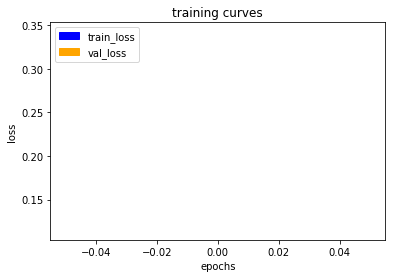

200/200 [==============================] - 94s - loss: 0.3409 - val_loss: 0.1151
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0466

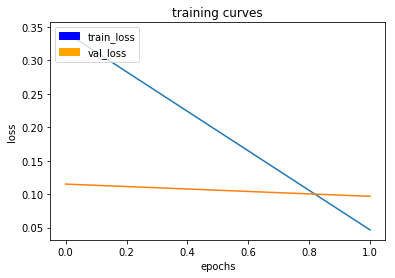

200/200 [==============================] - 103s - loss: 0.0466 - val_loss: 0.0968
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0373

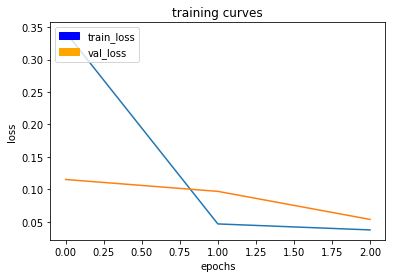

200/200 [==============================] - 103s - loss: 0.0373 - val_loss: 0.0536
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0341

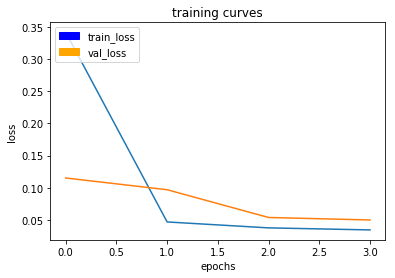

200/200 [==============================] - 102s - loss: 0.0341 - val_loss: 0.0497
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0318

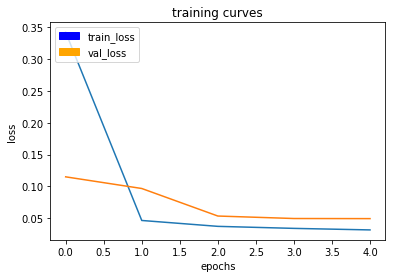

200/200 [==============================] - 103s - loss: 0.0318 - val_loss: 0.0495
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0295

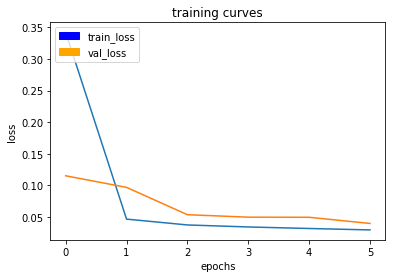

200/200 [==============================] - 103s - loss: 0.0295 - val_loss: 0.0397
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0278

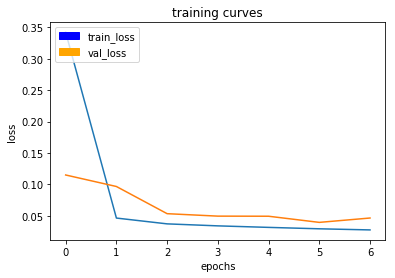

200/200 [==============================] - 104s - loss: 0.0278 - val_loss: 0.0467
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0278

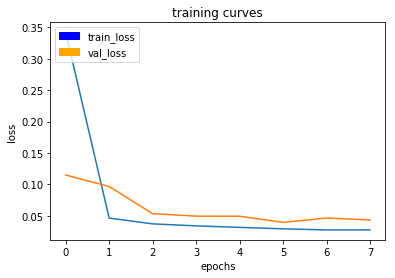

200/200 [==============================] - 103s - loss: 0.0278 - val_loss: 0.0436
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0248

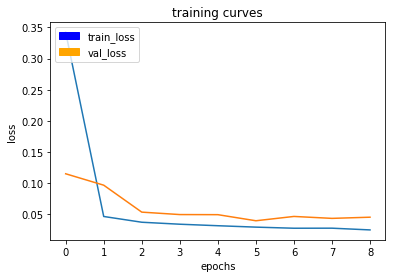

200/200 [==============================] - 103s - loss: 0.0250 - val_loss: 0.0454
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0263

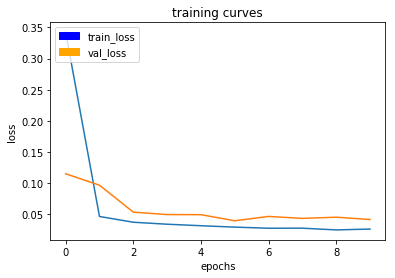

200/200 [==============================] - 102s - loss: 0.0263 - val_loss: 0.0417


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [12]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction<a id='prediction'></a>

In [13]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

In [14]:
# generate predictions, save in the runs, directory.
run_number = 'run1'
validation_path, output_path = model_tools.write_predictions_grade_set(model,run_number,'validation')

('../data/../data/validation/images/4_run2cam1_00280.jpeg', '../data/../data/validation/masks/4_run2_mask_00280.png')


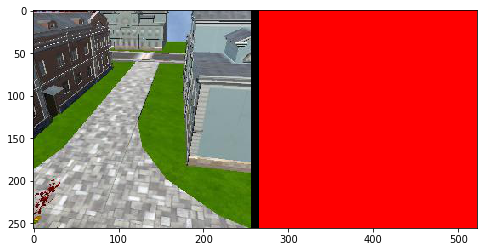

('../data/../data/validation/images/4_run2cam1_00479.jpeg', '../data/../data/validation/masks/4_run2_mask_00479.png')


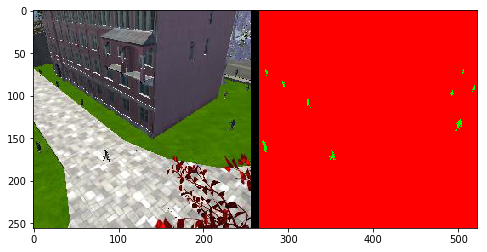

('../data/../data/validation/images/6_run1cam1_00046.jpeg', '../data/../data/validation/masks/6_run1_mask_00046.png')


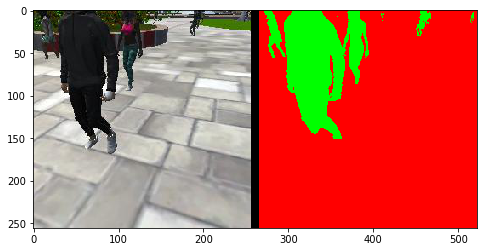

In [15]:
# take a look at predictions
# validation_path = 'validation'
im_files = plotting_tools.get_im_file_sample(run_number,validation_path)

for i in range(3):
    print(im_files[i])
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation<a id='evaluation'></a>
Let's evaluate your model!

In [16]:
scoring_utils.score_run(validation_path, output_path)

number of validation samples intersection over the union evaulated on 1184
average intersection over union for background is 0.9913144357919437
average intersection over union for other people is 0.30619584740957917
average intersection over union for hero is 0.1434027769349231
global average intersection over union is 0.48030435337881533
